In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.optim import Adam
from tqdm import tqdm
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Создание и нормализация обучающей, тестовой и выборки валидации

batch_size = 128

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128, 128)),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_path = "C:/Users/das-s/Downloads/Plants Classification/train"
train_ds = datasets.ImageFolder(root=train_path, transform=transform)
train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

test_path = "C:/Users/das-s/Downloads/Plants Classification/test"
test_ds = datasets.ImageFolder(root=test_path, transform=transform)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

validation_path = "C:/Users/das-s/Downloads/Plants Classification/val"
validation_ds = datasets.ImageFolder(root=validation_path, transform=transform)
validation_dataloader = DataLoader(validation_ds, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Feature batch shape: torch.Size([128, 3, 128, 128])
Labels batch shape: torch.Size([128])


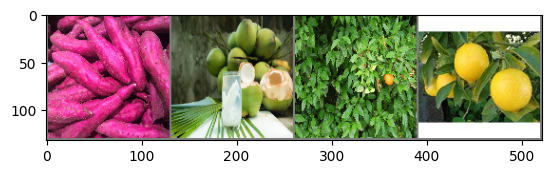

sweetpotatoes	 coconut	 orange	 orange	


In [24]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
images = []
for i in range(4):
    images.append(train_features[i])
imshow(torchvision.utils.make_grid(images)) # show images
print(' '.join(f'{train_ds.classes[train_labels[j]]}\t' for j in range(4))) # print labels


In [6]:
class CNN(nn.Module):
    def __init__(self, channel, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(channel, 32, kernel_size=3),
                                    nn.BatchNorm2d(32),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3),
                                    nn.BatchNorm2d(64),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(128, 128, kernel_size=3),
                                    nn.BatchNorm2d(128),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer4 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3),
                                    nn.ReLU(),
                                    nn.Conv2d(256, 256, kernel_size=3),
                                    nn.BatchNorm2d(256),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc1 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(256*3*3, 512),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = x.view(-1, 256*3*3)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return nn.functional.softmax(x, dim=1)

In [7]:
model = CNN(3, len(test_ds.classes))
model.to(device)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    

In [9]:
def train(model, train_dataloader, optimizer, loss_func):
    model.train()
    print('Train')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for data, labels in tqdm(train_dataloader):
        counter += 1
        data = data.to(device)
        labels = labels.to(device)

        outputs = model(data)
        # calculate the loss
        loss = loss_func(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_dataloader.dataset))
    return epoch_loss, epoch_acc

In [10]:
def validate(model, validation_dataloader, loss_func):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for data, labels in tqdm(validation_dataloader):
            counter += 1
            data = data.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(data)
            # calculate the loss
            loss = loss_func(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validation_dataloader.dataset))
    return epoch_loss, epoch_acc

In [11]:
optimizer = Adam(params=model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
num_epochs = 30

In [12]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1} of {num_epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, 
                                              optimizer, loss_func)
    valid_epoch_loss, valid_epoch_acc = validate(model, validation_dataloader,  
                                                 loss_func)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch 1 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Training loss: 1.979, training acc: 38.878
Validation loss: 2.043, validation acc: 32.333
--------------------------------------------------
Epoch 2 of 30
Train


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Training loss: 1.913, training acc: 45.218
Validation loss: 1.924, validation acc: 43.778
--------------------------------------------------
Epoch 3 of 30
Train


100%|██████████| 49/49 [00:19<00:00,  2.47it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Training loss: 1.888, training acc: 47.919
Validation loss: 1.928, validation acc: 44.111
--------------------------------------------------
Epoch 4 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Training loss: 1.891, training acc: 47.776
Validation loss: 1.975, validation acc: 39.222
--------------------------------------------------
Epoch 5 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.43it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.65it/s]


Training loss: 1.887, training acc: 48.141
Validation loss: 1.942, validation acc: 42.444
--------------------------------------------------
Epoch 6 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.37it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Training loss: 1.872, training acc: 49.396
Validation loss: 1.899, validation acc: 46.000
--------------------------------------------------
Epoch 7 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Training loss: 1.861, training acc: 50.779
Validation loss: 1.930, validation acc: 43.778
--------------------------------------------------
Epoch 8 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Training loss: 1.843, training acc: 52.606
Validation loss: 1.839, validation acc: 53.222
--------------------------------------------------
Epoch 9 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


Training loss: 1.835, training acc: 53.225
Validation loss: 1.887, validation acc: 48.111
--------------------------------------------------
Epoch 10 of 30
Train


100%|██████████| 49/49 [00:21<00:00,  2.33it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.52it/s]


Training loss: 1.822, training acc: 54.798
Validation loss: 1.840, validation acc: 53.111
--------------------------------------------------
Epoch 11 of 30
Train


100%|██████████| 49/49 [00:21<00:00,  2.32it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.53it/s]


Training loss: 1.803, training acc: 56.339
Validation loss: 1.845, validation acc: 52.000
--------------------------------------------------
Epoch 12 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Training loss: 1.878, training acc: 48.872
Validation loss: 1.967, validation acc: 39.667
--------------------------------------------------
Epoch 13 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.66it/s]


Training loss: 1.878, training acc: 49.190
Validation loss: 1.851, validation acc: 51.778
--------------------------------------------------
Epoch 14 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.41it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Training loss: 1.871, training acc: 49.571
Validation loss: 1.876, validation acc: 49.556
--------------------------------------------------
Epoch 15 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.57it/s]


Training loss: 1.884, training acc: 48.411
Validation loss: 1.936, validation acc: 43.222
--------------------------------------------------
Epoch 16 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Training loss: 1.850, training acc: 51.573
Validation loss: 1.871, validation acc: 49.333
--------------------------------------------------
Epoch 17 of 30
Train


100%|██████████| 49/49 [00:21<00:00,  2.30it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Training loss: 1.862, training acc: 50.540
Validation loss: 1.990, validation acc: 36.889
--------------------------------------------------
Epoch 18 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Training loss: 1.843, training acc: 52.717
Validation loss: 1.862, validation acc: 50.667
--------------------------------------------------
Epoch 19 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


Training loss: 1.826, training acc: 54.210
Validation loss: 1.897, validation acc: 47.111
--------------------------------------------------
Epoch 20 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


Training loss: 1.808, training acc: 55.767
Validation loss: 1.852, validation acc: 51.111
--------------------------------------------------
Epoch 21 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Training loss: 1.805, training acc: 56.371
Validation loss: 1.808, validation acc: 56.111
--------------------------------------------------
Epoch 22 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Training loss: 1.806, training acc: 56.276
Validation loss: 1.875, validation acc: 49.111
--------------------------------------------------
Epoch 23 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Training loss: 1.817, training acc: 55.100
Validation loss: 1.878, validation acc: 49.333
--------------------------------------------------
Epoch 24 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Training loss: 1.817, training acc: 55.116
Validation loss: 1.873, validation acc: 49.333
--------------------------------------------------
Epoch 25 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.39it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]


Training loss: 1.805, training acc: 56.196
Validation loss: 1.842, validation acc: 52.667
--------------------------------------------------
Epoch 26 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.40it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.58it/s]


Training loss: 1.783, training acc: 58.643
Validation loss: 1.799, validation acc: 57.111
--------------------------------------------------
Epoch 27 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.60it/s]


Training loss: 1.799, training acc: 57.023
Validation loss: 1.825, validation acc: 54.222
--------------------------------------------------
Epoch 28 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.36it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.63it/s]


Training loss: 1.779, training acc: 58.866
Validation loss: 1.799, validation acc: 57.111
--------------------------------------------------
Epoch 29 of 30
Train


100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.62it/s]


Training loss: 1.773, training acc: 59.390
Validation loss: 1.792, validation acc: 57.778
--------------------------------------------------
Epoch 30 of 30
Train


100%|██████████| 49/49 [00:19<00:00,  2.46it/s]


Validation


100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

Training loss: 1.765, training acc: 60.423
Validation loss: 1.818, validation acc: 55.000
--------------------------------------------------


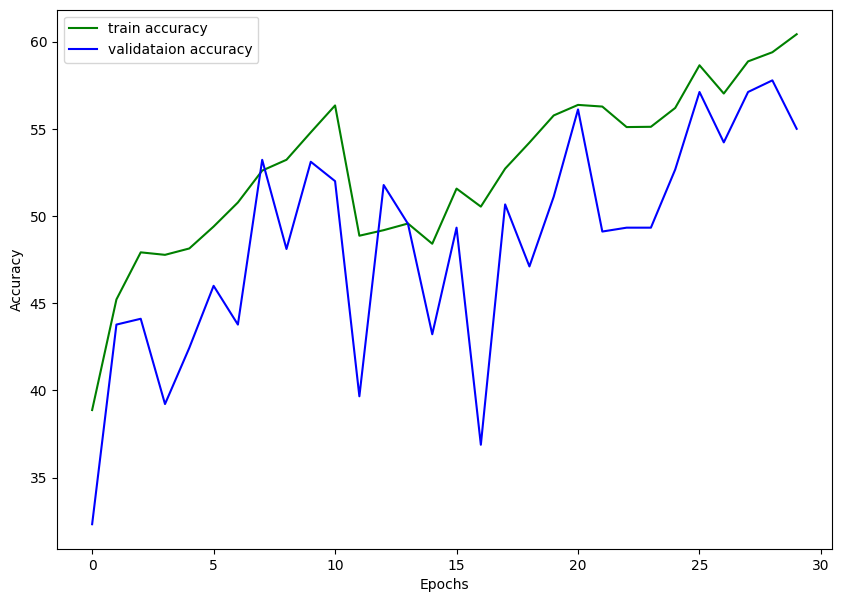

In [13]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_acc, color='green', linestyle='-', 
    label='train accuracy'
)
plt.plot(
    valid_acc, color='blue', linestyle='-', 
    label='validataion accuracy'
)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

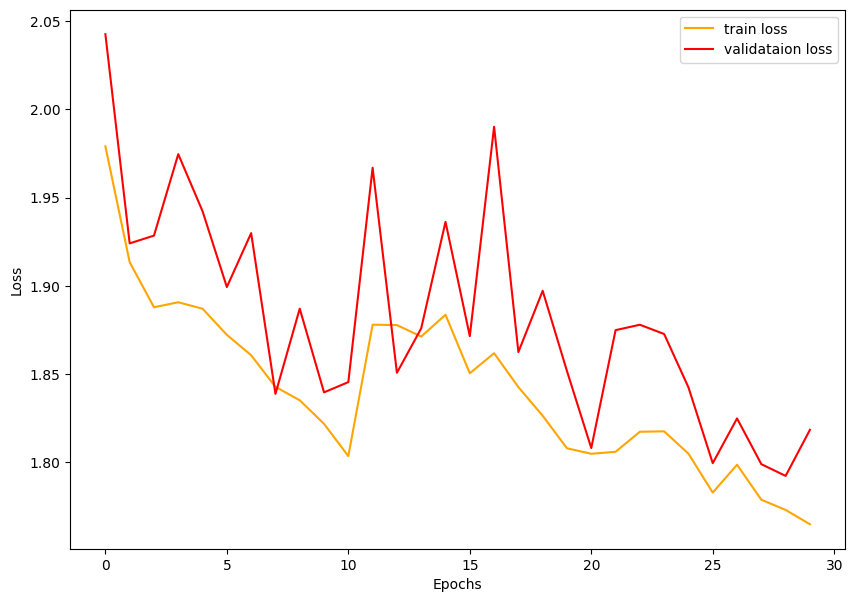

In [14]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(
    train_loss, color='orange', linestyle='-', 
    label='train loss')
plt.plot(
    valid_loss, color='red', linestyle='-', 
    label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

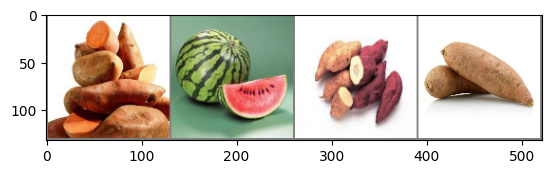

Real value:
sweetpotatoes	 watermelon	 sweetpotatoes	 sweetpotatoes	
Predicted value:
sweetpotatoes	 watermelon	 sweetpotatoes	 sweetpotatoes	


In [36]:
test_fetures, test_labels = next(iter(test_dataloader))
images = []
for i in range(4):
    images.append(test_fetures[i])
imshow(torchvision.utils.make_grid(images)) # show images
print("Real value:")
print(' '.join(f'{train_ds.classes[test_labels[j]]}\t' for j in range(4))) # print labels
print("Predicted value:")
print(' '.join(f'{train_ds.classes[model(test_fetures[j].view(1, 3, 128, 128).to(device)).argmax()]}\t' for j in range(4)))

In [26]:
real_labels = []
predicted_labels = []
for data, labels in test_dataloader:
    data = data.to(device)
    output = model(data).argmax(dim=1).cpu().detach().numpy()
    for i in range(len(output)):
        predicted_labels.append(output[i])
        real_labels.append(labels[i].detach().item())

In [27]:
from sklearn.metrics import classification_report

print(classification_report(predicted_labels, real_labels, target_names=test_ds.classes))

               precision    recall  f1-score   support

     aloevera       0.43      0.74      0.54       117
       banana       0.00      0.00      0.00         0
      coconut       0.46      0.46      0.46       196
     cucumber       0.69      0.46      0.55       298
       orange       0.34      0.37      0.35       185
       papaya       0.81      0.71      0.76       227
      spinach       0.52      0.40      0.45       255
sweetpotatoes       0.80      0.59      0.68       272
   watermelon       0.94      0.78      0.85       242

     accuracy                           0.55      1792
    macro avg       0.55      0.50      0.52      1792
 weighted avg       0.65      0.55      0.59      1792



c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\das-s\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le